In [1]:
!pip -q install pandas numpy scikit-learn textblob textstat tqdm

import nltk, json, os, pathlib
nltk.download('brown', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00


True

In [2]:

kaggle_json = {"username": "YOUR_USERNAME", "key": "YOUR_API_KEY"}

home = pathlib.Path("~/.kaggle").expanduser()
home.mkdir(parents=True, exist_ok=True)
with open(home / "kaggle.json", "w") as f:
    json.dump(kaggle_json, f)
os.chmod(home / "kaggle.json", 0o600)

!kaggle datasets download -d mexwell/fake-reviews-dataset -q
!unzip -o fake-reviews-dataset.zip -d data > /dev/null


Dataset URL: https://www.kaggle.com/datasets/mexwell/fake-reviews-dataset
License(s): Attribution 4.0 International (CC BY 4.0)


In [3]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from tqdm.notebook import tqdm
from textblob import TextBlob
import textstat, re, string, itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
plt.style.use("default")


In [4]:
df = pd.read_csv("data/fake reviews dataset.csv")
display(df.head())
print("Shape:", df.shape, "\nClass counts:\n", df["label"].value_counts())


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


Shape: (40432, 4) 
Class counts:
 label
CG    20216
OR    20216
Name: count, dtype: int64


In [5]:
def clean_text(txt: str) -> str:
    if pd.isna(txt):
        return ""
    txt = txt.lower()
    txt = re.sub(r"[^\w\s]", " ", txt)
    return re.sub(r"\s+", " ", txt).strip()

df["clean_text"] = df["text_"].apply(clean_text)



df[["text_","clean_text"]].head()


,text_,clean_text
0,"Love this! Well made, sturdy, and very comfor...",love this well made sturdy and very comfortabl...
1,"love it, a great upgrade from the original. I...",love it a great upgrade from the original i ve...
2,This pillow saved my back. I love the look and...,this pillow saved my back i love the look and ...
3,"Missing information on how to use it, but it i...",missing information on how to use it but it is...
4,Very nice set. Good quality. We have had the s...,very nice set good quality we have had the set...


In [6]:
def base_features(txt: str):
    if not txt:
        return 0, 0, 0, 0
    blob = TextBlob(txt)
    sent = (blob.sentiment.polarity + 1) / 2        # 0-1
    subj = blob.sentiment.subjectivity
    read = np.clip(textstat.flesch_reading_ease(txt) / 100, 0, 1)
    leng = np.clip(len(txt.split()) / 300, 0, 1)
    return sent, subj, read, leng

tqdm.pandas(desc="Extracting features")
df[["sent", "subj", "read", "leng"]] = df["clean_text"].progress_apply(
    lambda t: pd.Series(base_features(t))
)

def tone_mismatch(row) -> int:
    star = row["rating"]          # 1-5
    tone = row["sent"]            # 0-1
    return int((star >= 4 and tone < 0.4) or (star <= 2 and tone > 0.6))

df["mismatch"] = df.apply(tone_mismatch, axis=1)


df.head()


Extracting features:   0%|          | 0/40432 [00:00<?, ?it/s]

,category,rating,label,text_,clean_text,sent,subj,read,leng,mismatch
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",love this well made sturdy and very comfortabl...,0.730625,0.8,0.634862,0.043333,0
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",love it a great upgrade from the original i ve...,0.779167,0.7,0.800976,0.056667,0
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,this pillow saved my back i love the look and ...,0.625000,0.3,0.959393,0.046667,0
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",missing information on how to use it but it is...,0.650000,0.4,0.800976,0.056667,1
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,very nice set good quality we have had the set...,0.870000,0.8,0.898650,0.060000,0


In [7]:
X_text = df["text_"].values
X_rate = df["rating"].values
y      = (df["label"].str.upper() == "CG").astype(int).values

Xtr_txt, Xte_txt, Xtr_rt, Xte_rt, y_tr, y_te = train_test_split(
    X_text, X_rate, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("Train:", Xtr_txt.shape, "  Test:", Xte_txt.shape)


Train: (32345,)   Test: (8087,)


In [10]:
def train_eval(model, name):
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=40_000)),
        ("clf"  , model)
    ])
    pipe.fit(Xtr_txt, y_tr)
    f1 = f1_score(y_te, pipe.predict(Xte_txt))
    print(f"{name:10s}  F1 = {f1:.4f}")
    return f1

f1_lr  = train_eval(LogisticRegression(max_iter=400, n_jobs=-1), "LogReg")
f1_svm = train_eval(LinearSVC(),                               "SVM")
f1_rf  = train_eval(RandomForestClassifier(
                      n_estimators=300, n_jobs=-1,
                      class_weight="balanced"),                "RandForest")


LogReg      F1 = 0.8702
SVM         F1 = 0.8750
RandForest  F1 = 0.8621


In [8]:
# triangular membership functions
def low(x):  return np.clip(1 - 2*x,             0, 1)
def high(x): return np.clip(2*x - 1,             0, 1)
def med(x):  return np.clip(1 - 2*np.abs(x-0.5), 0, 1)

# initial weights (will be tuned)
PROB = {"low": 0.15, "med": 0.50, "high": 0.80}
MISMATCH_W = 0.60

def rule_strengths(s, u, r, l, m):
    yield min(s["high"], u["high"], r["low"]),  "high"
    yield min(s["high"], u["high"], l["high"]), "high"
    yield min(s["low"] , u["low"] , r["high"]), "low"
    yield min(r["low"] , l["high"]),            "high"
    yield min(s["med"] , u["med"] , r["med"]),  "med"
    yield min(s["low"] , u["high"]),            "med"
    yield min(s["high"], r["high"]),            "low"
    yield min(u["low"] , r["low"]),             "med"
    yield min(l["low"] , r["high"]),            "low"
    # mismatch → gentle boost
    yield (m * MISMATCH_W),                     "high"

def frds_prob(text: str, rating: float) -> float:
    s_val, u_val, r_val, l_val = base_features(clean_text(text))
    m_flag = tone_mismatch({"rating": rating, "sent": s_val})

    s = {"low": low(s_val),  "med": med(s_val),  "high": high(s_val)}
    u = {"low": low(u_val),  "med": med(u_val),  "high": high(u_val)}
    r = {"low": low(r_val),  "med": med(r_val),  "high": high(r_val)}
    l = {"low": low(l_val),  "med": med(l_val),  "high": high(l_val)}

    num = den = 0.0
    for strength, lbl in rule_strengths(s, u, r, l, m_flag):
        num += strength * PROB[lbl]
        den += strength
    return num / den if den else 0.5


In [9]:
grid_low       = [0.12, 0.15, 0.18]
grid_med       = [0.48, 0.52, 0.56]
grid_high      = [0.78, 0.82, 0.86]
grid_mismatchW = [0.40, 0.55, 0.70]
grid_thresh    = np.linspace(0.20, 0.70, 11)   # step 0.05

best_cfg = None
best_f1  = 0

probs_all = np.array([
    frds_prob(t, r) for t, r in tqdm(
        zip(Xte_txt, Xte_rt),
        total=len(Xte_txt),
        desc="FRDS inference")
])

for lo, me, hi, mw in itertools.product(
        grid_low, grid_med, grid_high, grid_mismatchW):
    PROB.update({"low": lo, "med": me, "high": hi})
    MISMATCH_W = mw
    for t in grid_thresh:
        f1_val = f1_score(y_te, (probs_all >= t).astype(int))
        if f1_val > best_f1:
            best_f1  = f1_val
            best_cfg = (lo, me, hi, mw, t)

lo, me, hi, mw, best_t = best_cfg
PROB.update({"low": lo, "med": me, "high": hi})
MISMATCH_W = mw
y_pred_frds = (probs_all >= best_t).astype(int)

print(
    f"Best configuration  PROB=({lo:.2f},{me:.2f},{hi:.2f}), "
    f"MISMATCH_W={mw:.2f}, threshold={best_t:.2f}\n"
    f"FRDS F1 = {best_f1:.4f}"
)


FRDS inference:   0%|          | 0/8087 [00:00<?, ?it/s]

Best configuration  PROB=(0.12,0.48,0.78), MISMATCH_W=0.40, threshold=0.20
FRDS F1 = 0.6372


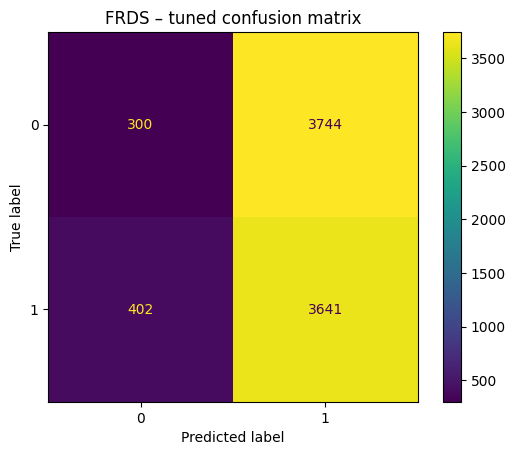

In [11]:
cm = confusion_matrix(y_te, y_pred_frds)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(values_format='d')
plt.title("FRDS – tuned confusion matrix")
plt.show()


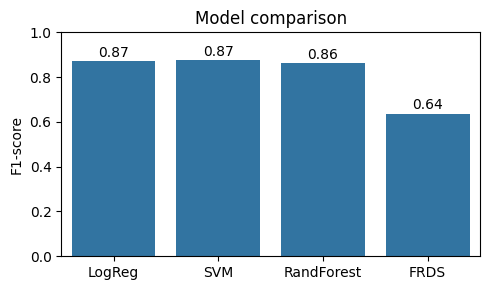

In [12]:
models = ["LogReg", "SVM", "RandForest", "FRDS"]
f1s    = [f1_lr,    f1_svm, f1_rf,       best_f1]

plt.figure(figsize=(5, 3))
sns.barplot(x=models, y=f1s)
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.title("Model comparison")
for i, v in enumerate(f1s):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()


In [13]:
def traffic(p):
    return "Green" if p <= 0.30 else "Amber" if p <= 0.60 else "Red"

demo = pd.DataFrame({"review": Xte_txt[:5], "rating": Xte_rt[:5]})
demo["P(fake)"] = demo.apply(
    lambda r: frds_prob(r["review"], r["rating"]), axis=1
)
demo["label"] = demo["P(fake)"].apply(traffic)
display(demo)


,review,rating,P(fake),label
0,My grandson loves to experience the real world...,5.0,0.274380,Green
1,Just as advertised! Perfect for keeping on a d...,5.0,0.193664,Green
2,I take a size 10D and it fits fine. I will ke...,5.0,0.145366,Green
3,Of all the recipe books I have seen to date wh...,5.0,0.401920,Amber
4,Colors are off white & a pink red color. Retur...,2.0,0.171410,Green


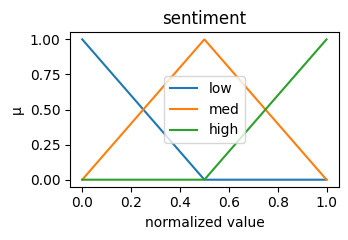

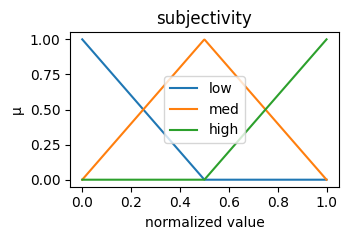

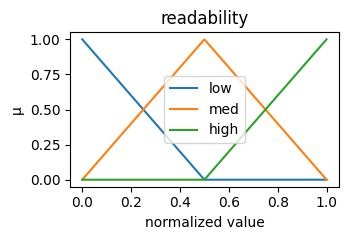

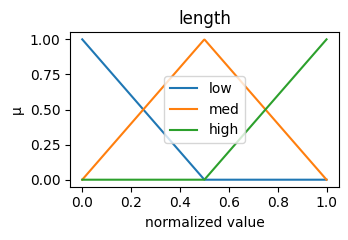

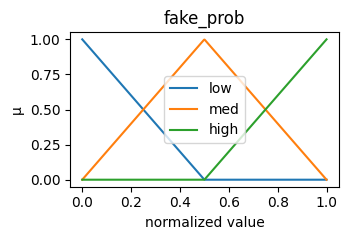

In [14]:
def plot_mf(var_name):
    x = np.linspace(0, 1, 500)
    plt.figure(figsize=(3.5, 2.5))
    plt.plot(x, low(x),  label="low")
    plt.plot(x, med(x),  label="med")
    plt.plot(x, high(x), label="high")
    plt.title(var_name)
    plt.xlabel("normalized value")
    plt.ylabel("μ")
    plt.legend()
    plt.tight_layout()
    plt.show()

for name in ["sentiment", "subjectivity", "readability", "length", "fake_prob"]:
    plot_mf(name)
